In [1]:
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import sys, fitz
import spacy
from spacy.matcher import PhraseMatcher
from spacy.matcher import Matcher
import en_core_web_sm
nlp = en_core_web_sm.load()

In [29]:
# read resumes from the folder one by one
mypath='/data/Resume_folder' #enter your path here where you saved the resumes
onlyfiles = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
print(len(onlyfiles))
final_database=pd.DataFrame()

29


In [18]:
def pdfextract(file):
    doc = fitz.open(file)
    print("No of Pages:", doc.pageCount)
    text = []
    extracted_text = ""
    for page in doc:
        t = page.getText("text")
        extracted_text = extracted_text + str(t)
        #text.append(t)
    return extracted_text.lower()

In [21]:
#function that does phrase matching and builds a candidate profile
def create_profile(file):
    text = pdfextract(file) 
    #text = str(text)
    #text = text.replace("\\n", "")
    #text = text.lower()
    #below is the csv where we have all the keywords, you can customize your own
    keyword_dict = pd.read_csv('/data/template_new.csv', encoding= 'unicode_escape')
    stats_words = [nlp(text) for text in keyword_dict['Statistics'].dropna(axis = 0)]
    NLP_words = [nlp(text) for text in keyword_dict['NLP'].dropna(axis = 0)]
    ML_words = [nlp(text) for text in keyword_dict['Machine learning'].dropna(axis = 0)]
    DL_words = [nlp(text) for text in keyword_dict['Deep learning'].dropna(axis = 0)]
    R_words = [nlp(text) for text in keyword_dict['R language'].dropna(axis = 0)]
    python_words = [nlp(text) for text in keyword_dict['Python language'].dropna(axis = 0)]
    Data_Engineering_words = [nlp(text) for text in keyword_dict['Data Engineering'].dropna(axis = 0)]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('ML', None, *ML_words)
    matcher.add('DL', None, *DL_words)
    matcher.add('R', None, *R_words)
    matcher.add('Python', None, *python_words)
    matcher.add('DE', None, *Data_Engineering_words)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    
    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
       
    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)
    print(dataf)

    return(dataf)
        
#function ends

In [30]:
j=0
while j < len(onlyfiles):
    file = onlyfiles[j]
    dat = create_profile(file)
    final_database = final_database.append(dat)
    j +=1

print(final_database)

No of Pages: 1
  Candidate Name Subject                       Keyword Count
0          vivek   Stats                  probability      1
1          vivek     NLP  natural language processing      1
2          vivek  Python                       python      1
3          vivek  Python                        numpy      1
4          vivek      DL                        keras      1
5          vivek  Python                       pandas      1
6          vivek  Python                   matplotlib      1
No of Pages: 2
      Candidate Name Subject       Keyword Count
0  shivanjali kaveti   Stats  probability      1
1  shivanjali kaveti      DE          sql      1
No of Pages: 2
       Candidate Name Subject  Keyword Count
0  rajkumar santhanam  Python  python      1
No of Pages: 1
  Candidate Name Subject  Keyword Count
0        sandesh  Python  python      2
1        sandesh  Python  django      1
No of Pages: 2
  Candidate Name Subject  Keyword Count
0  rahulwankhede      DE  hadoop      1


In [31]:
final_database2 = final_database['Keyword'].groupby([final_database['Candidate Name'], final_database['Subject']]).count().unstack()
final_database2.reset_index(inplace = True)
final_database2.fillna(0,inplace=True)
print(final_database2)
new_data = final_database2.iloc[:,1:]
new_data.index = final_database2['Candidate Name']

Subject          Candidate Name   DE   DL   ML  NLP  Python  Stats
0              aditya kumar pal  0.0  2.0  0.0  0.0     1.0    0.0
1             ajith kumar panja  1.0  2.0  0.0  0.0     1.0    0.0
2                 akansha dimri  0.0  0.0  4.0  0.0     0.0    0.0
3                    anik goyal  0.0  0.0  0.0  0.0     1.0    0.0
4            ankit singh pundir  0.0  0.0  0.0  0.0     3.0    0.0
5                  anusha reddy  0.0  1.0  0.0  0.0     1.0    0.0
6                        balaji  0.0  0.0  0.0  0.0     1.0    0.0
7               dhibahar selvam  1.0  0.0  0.0  0.0     0.0    0.0
8                   jayashree j  1.0  0.0  0.0  0.0     0.0    1.0
9                    laxman b r  0.0  0.0  0.0  0.0     2.0    0.0
10                  manohar lal  0.0  0.0  0.0  0.0     4.0    0.0
11       modukuri sumanth kumar  0.0  0.0  0.0  0.0     1.0    0.0
12               nabarun sarkar  0.0  3.0  0.0  0.0     0.0    1.0
13                 nilesh rathi  0.0  1.0  0.0  0.0     1.0   

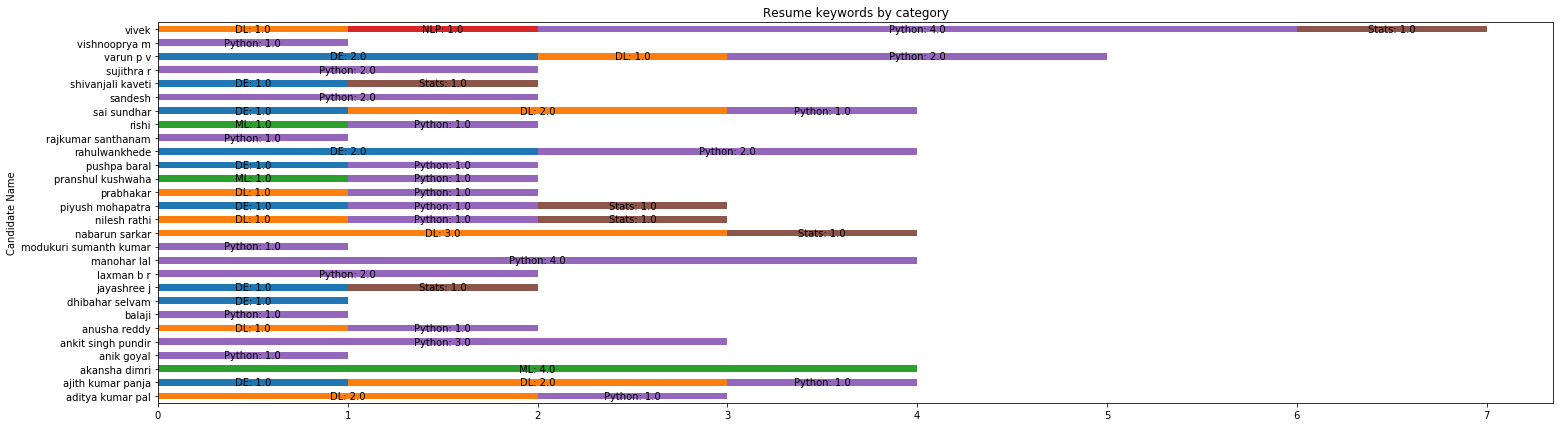

In [32]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
ax = new_data.plot.barh(title="Resume keywords by category", legend=False, figsize=(25,7), stacked=True)
labels = []
for j in new_data.columns:
    for i in new_data.index:
        label = str(j)+": " + str(new_data.loc[i][j])
        labels.append(label)
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')
plt.show()

In [33]:
#Top 5 candidates for each job post.

sort_df = pd.DataFrame() # here, we will store only top 5 candidates names in each column. here each column will be a job role.
for role in range(len(final_database2.iloc[:,1:].columns)):
  #print("role value:", role)
    names = (final_database2.sort_values(final_database2.columns[role+1],axis = 0, inplace=False, ascending=False)).head().iloc[:, 0]  # names is of type object
    sort_df[final_database2.columns[role+1]] = list(names)
    role += 1


print("top 5 candidates in each role")
print(sort_df)

top 5 candidates in each role
                  DE                 DL                 ML                NLP  \
0          varun p v     nabarun sarkar      akansha dimri              vivek   
1      rahulwankhede   aditya kumar pal              rishi  ajith kumar panja   
2   piyush mohapatra        sai sundhar  pranshul kushwaha      vishnooprya m   
3  shivanjali kaveti  ajith kumar panja   aditya kumar pal          varun p v   
4    dhibahar selvam          varun p v          prabhakar         sujithra r   

               Python              Stats  
0               vivek   piyush mohapatra  
1         manohar lal        jayashree j  
2  ankit singh pundir  shivanjali kaveti  
3           varun p v       nilesh rathi  
4          sujithra r     nabarun sarkar  


In [34]:
# get top candidates for particular job post 

job_post = input("Enter job post to get top 5 selected candidates:")

if job_post in sort_df.columns:
    print("Top 5 candidates are:") 
    print(sort_df[job_post])
else:
    print("No candidates available for this job post")

Enter job post to get top 5 selected candidates: Stats


Top 5 candidates are:
0     piyush mohapatra
1          jayashree j
2    shivanjali kaveti
3         nilesh rathi
4       nabarun sarkar
Name: Stats, dtype: object
